# Instance Segmentation

Inspired from https://colab.research.google.com/drive/11MqMCyF_V7Rkw6b9CCShGfNTP59OJ905?usp=sharing

Configure runtime environment
```python
!pip install -U openmim
!mim install "mmengine>=0.7.0"
!mim install "mmcv>=2.0.0rc4"

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .
```

In [1]:
# Check Pytorch installation
import torch, torchvision
print("torch version:",torch.__version__, "cuda:",torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print("mmdetection:",mmdet.__version__)

# Check mmcv installation
import mmcv
print("mmcv:",mmcv.__version__)

# Check mmengine installation
import mmengine
print("mmengine:",mmengine.__version__)


/opt/conda/envs/openmmlab_3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch version: 1.13.1 cuda: True
(2, 1, 0, 0, 0, 0) (0, 10, 3, 0, 0, 0)
mmdetection: 3.3.0
mmcv: 2.1.0
mmengine: 0.10.3


## Configure training

In [2]:
# !mim download mmdet --config mask-rcnn_swin-s-p4-w7_fpn_amp-ms-crop-3x_coco --dest ./checkpoints

In [3]:
# !wget https://huggingface.co/OpenGVLab/InternImage/resolve/main/internimage_t_1k_224.pth

In [4]:
import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules

config_file = './mmdet_checkpoints/mask-rcnn_swin-s-p4-w7_fpn_amp-ms-crop-3x_coco.py'
checkpoint_file = './mmdet_checkpoints/mask_rcnn_swin-s-p4-w7_fpn_fp16_ms-crop-3x_coco_20210903_104808-b92c91f1.pth'

In [5]:
# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0') 

Loads checkpoint by local backend from path: ./mmdet_checkpoints/mask_rcnn_swin-s-p4-w7_fpn_fp16_ms-crop-3x_coco_20210903_104808-b92c91f1.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape i

### Dataset

In [6]:
from pycocotools.coco import COCO

# Path to load the COCO annotation file
annotation_file = './roboflow_datasets/xmm_om_artefacts_512-3-COCO/train/_annotations.coco.json'

# Initialise the COCO object
coco = COCO(annotation_file)

# Get all category tags and corresponding category IDs
categories = coco.loadCats(coco.getCatIds())
category_id_to_name = {cat['id']: cat['name'] for cat in categories}

# Print all category IDs and corresponding category names
for category_id, category_name in category_id_to_name.items():
    print(f"Category ID: {category_id}, Category Name: {category_name}")

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Category ID: 0, Category Name: artefacts
Category ID: 1, Category Name: central-ring
Category ID: 2, Category Name: smoke-ring
Category ID: 3, Category Name: star-loop


### Modify the config

In [7]:
from mmengine import Config
cfg = Config.fromfile(config_file)

In [11]:
from mmengine.runner import set_random_seed
from datetime import datetime

classes = ('central-ring', 'smoke-ring','star-loop')
cfg.metainfo = {
    'classes': classes,
    'palette': [
        (220, 20, 60), (220, 20, 60), (220, 20, 60), (220, 20, 60)
    ]
}

cfg.data_root = './roboflow_datasets/xmm_om_artefacts_512-3-COCO/'

cfg.train_dataloader.dataset.ann_file = 'train/_annotations.coco.json'
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix.img = 'train/'
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

cfg.val_dataloader.dataset.ann_file = 'valid/_annotations.coco.json'
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix.img = 'valid/'
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

cfg.test_dataloader = cfg.val_dataloader
cfg.val_evaluator.ann_file = cfg.data_root+'valid/_annotations.coco.json'
cfg.test_evaluator = cfg.val_evaluator

cfg.model.roi_head.bbox_head.num_classes = 4
cfg.model.roi_head.mask_head.num_classes = 4
cfg.load_from = checkpoint_file
cfg.work_dir = './mmdet_work_dir'

cfg.train_cfg.val_interval = 3 # reduce the evaluation times
cfg.default_hooks.checkpoint.interval = 3 # checkpoint saving
cfg.visualizer.vis_backends = [
        dict(type='LocalVisBackend'),
        dict(type='WandbVisBackend', 
             init_kwargs=dict(project="mmdet_train"), 
             name=f'{datetime.now()}')]

# The original learning rate (LR) is set for 8-GPU training.
cfg.optim_wrapper.optimizer.lr = 0.02 / 8
cfg.default_hooks.logger.interval = 10

# Set seed for now
cfg.seed = 0
set_random_seed(0, deterministic=False)

with open(config_file, 'w') as f:
    f.write(cfg.pretty_text)

In [12]:
cfg.visualizer.vis_backends = cfg.visualizer.vis_backends[:1]
cfg.visualizer.vis_backends

[{'type': 'LocalVisBackend'}]

In [13]:
cfg.visualizer

{'name': 'visualizer',
 'type': 'DetLocalVisualizer',
 'vis_backends': [{'type': 'LocalVisBackend'}]}

## Train the new detector

In [14]:
import sys
print(sys.executable)

/opt/conda/envs/openmmlab_3/bin/python3.8


**When simply using 'python', it will run from the env where jupyter was launched from. We need to specify the current env interpreter.**

In [12]:
!/opt/conda/envs/openmmlab_3/bin/python ../mmdetection/tools/train.py {config}

(2, 1, 0, 0, 0, 0) (0, 10, 3, 0, 0, 0)
./mmdet_checkpoints/mask-rcnn_swin-s-p4-w7_fpn_amp-ms-crop-3x_coco.py
./mmdet_work_dir ./mmdet_checkpoints/mask_rcnn_swin-s-p4-w7_fpn_fp16_ms-crop-3x_coco_20210903_104808-b92c91f1.pth
03/19 00:34:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.18 | packaged by conda-forge | (default, Dec 23 2023, 17:21:28) [GCC 12.3.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 386920598
    GPU 0,1,2,3: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.13.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2022.1-Product Build 20220311 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenM

In [67]:
# %pip install tensorboard  -i https://mirrors.ustc.edu.cn/pypi/web/simple

## Test the detector

In [49]:
import mmcv
from mmdet.apis import init_detector, inference_detector
img = mmcv.imread('../XMM_OM_dataset/zscaled_512_stretched/S0156960101_U.png',channel_order='rgb')
checkpoint_file = './mmdet_work_dir/epoch_36.pth'
model = init_detector(cfg, checkpoint_file, device='cpu')
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: ./mmdet_work_dir/epoch_36.pth
<DetDataSample(

    META INFORMATION
    pad_shape: (800, 800)
    img_path: None
    scale_factor: (1.5625, 1.5625)
    img_id: 0
    batch_input_shape: (800, 800)
    img_shape: (800, 800)
    ori_shape: (512, 512)

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            masks: tensor([[[False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         ...,
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False],
                         [False, False, False,  ..., False, False, False]],
                
                        [[False, False, False,  ..., False, False, False],
        

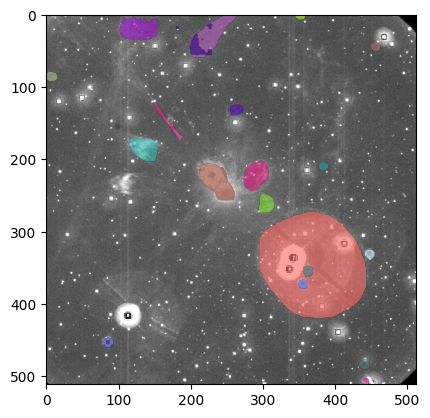

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import dataset
from dataset import dataset_utils

plt.imshow(img)
dataset_utils.show_masks(new_result.pred_instances.masks.cpu().numpy(), plt.gca(), random_color=True)
plt.show()
plt.close()

## Export new predictions to Roboflow

In [17]:
# !pip install roboflow

In [41]:
export_to_Roboflow = False

if export_to_Roboflow:
    import glob
    from roboflow import Roboflow
    # Initialize Roboflow client
    rf = Roboflow(api_key="api_key")
    upload_project = rf.workspace("username").project("project_name") # error if the project doesn't exist

In [43]:
import os
import dataset
from dataset import voc_annotate_and_Roboflow_export as voc_roboflow_exp
from dataset import dataset_utils

def mmdet_export_image_det_to_Roboflow(input_dir, filename, obj_results):
    class_labels = obj_results.labels.cpu().numpy()
    masks = obj_results.masks.cpu().numpy()
    objects = []
    
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        mask_np = masks[i]
        polygon = voc_roboflow_exp.binary_image_to_polygon(mask_np)
        bbox = dataset_utils.mask_to_bbox(mask_np)
        objects.append({
            'name': classes[class_labels[i]],
            'bbox': bbox,
            'segmentations': polygon[0]
        })
        
    if len(objects)>0:
        voc_roboflow_exp.create_annotation_SAM(filename=filename, width=512, height=512, depth=3, objects=objects, offset=1.2) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".png", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=True)
        os.remove(annotation_filename)
    else:
        print("No objects after label filtering.")

Image ../XMM_OM_dataset/zscaled_512_stretched/S0823480401_U.png


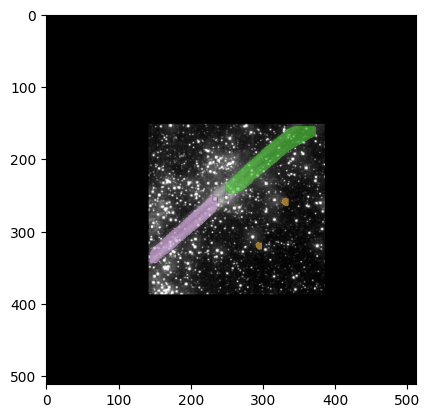

Image ../XMM_OM_dataset/zscaled_512_stretched/S0551030101_L.png


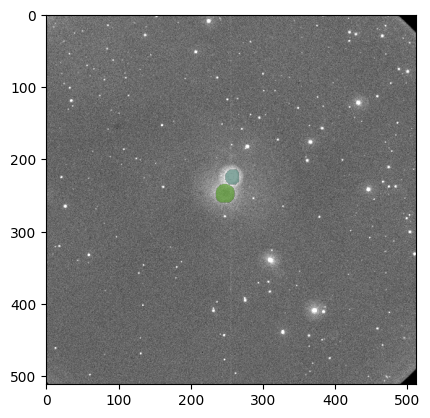

Image ../XMM_OM_dataset/zscaled_512_stretched/S0109930201_B.png


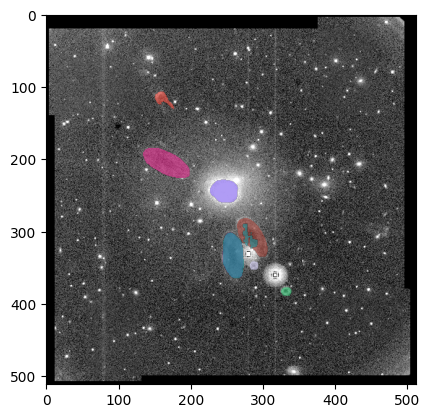

Image ../XMM_OM_dataset/zscaled_512_stretched/S0203160401_B.png


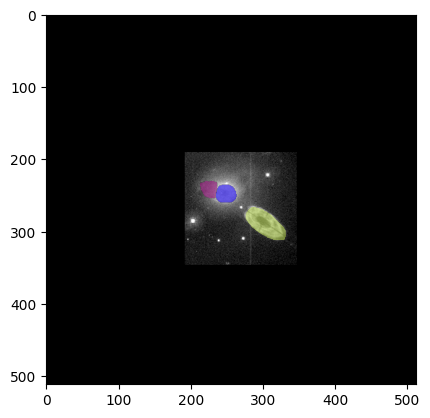

Image ../XMM_OM_dataset/zscaled_512_stretched/S0852590101_S.png


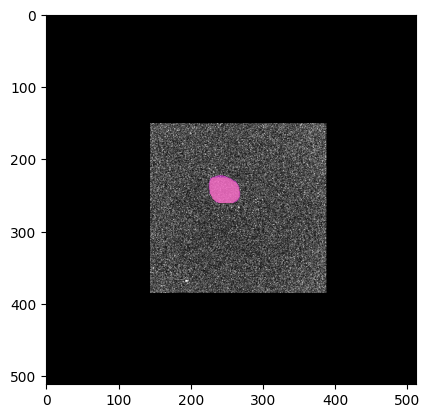

Image ../XMM_OM_dataset/zscaled_512_stretched/S0503590301_M.png


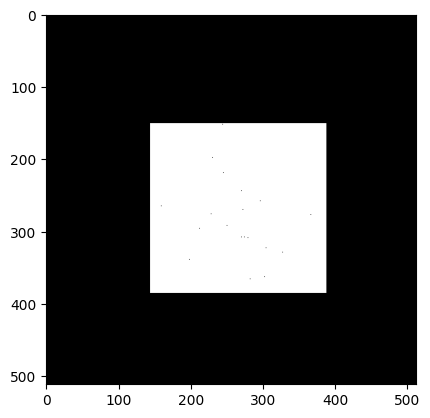

Image ../XMM_OM_dataset/zscaled_512_stretched/S0744210101_M.png


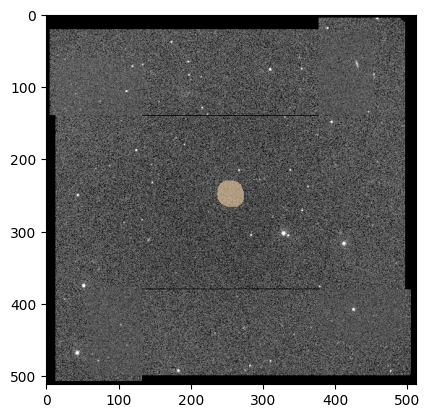

Image ../XMM_OM_dataset/zscaled_512_stretched/S0679181401_M.png


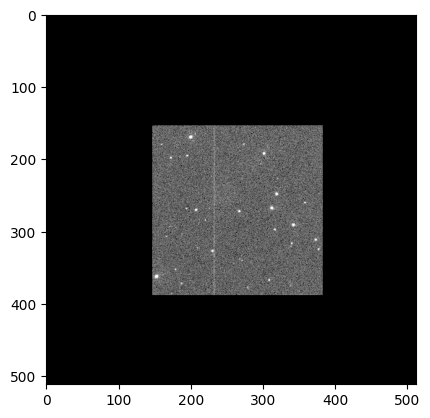

Image ../XMM_OM_dataset/zscaled_512_stretched/S0784370101_M.png


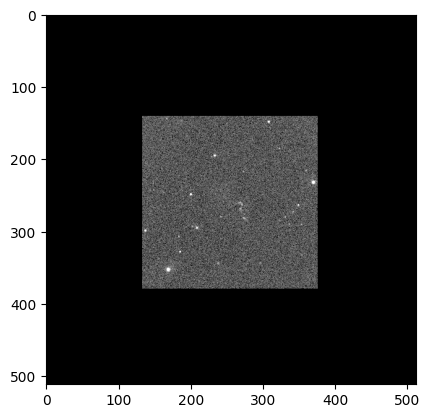

Image ../XMM_OM_dataset/zscaled_512_stretched/S0840141001_M.png


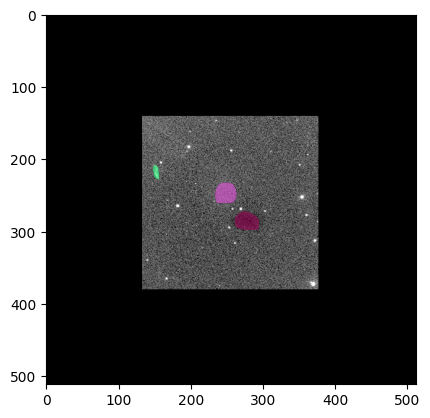

Image ../XMM_OM_dataset/zscaled_512_stretched/S0109464201_L.png


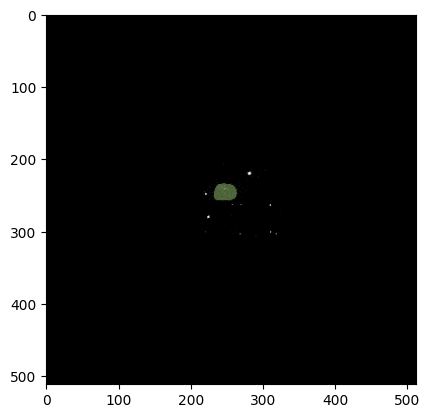

Image ../XMM_OM_dataset/zscaled_512_stretched/S0884190401_S.png


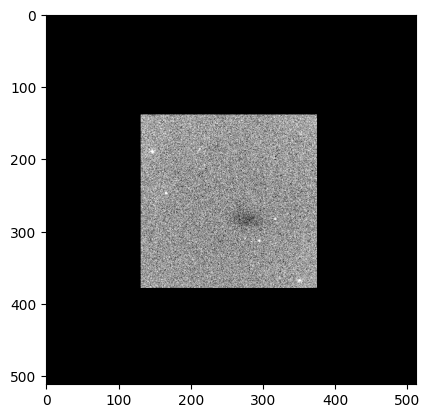

Image ../XMM_OM_dataset/zscaled_512_stretched/S0820770142_L.png


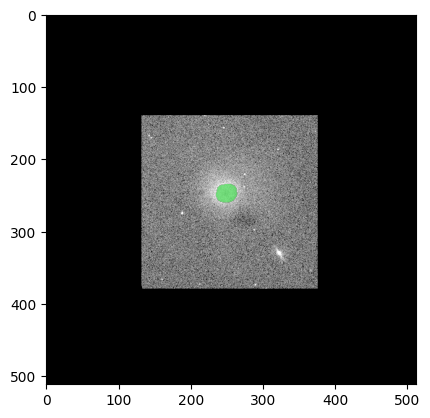

Image ../XMM_OM_dataset/zscaled_512_stretched/S0202060101_B.png


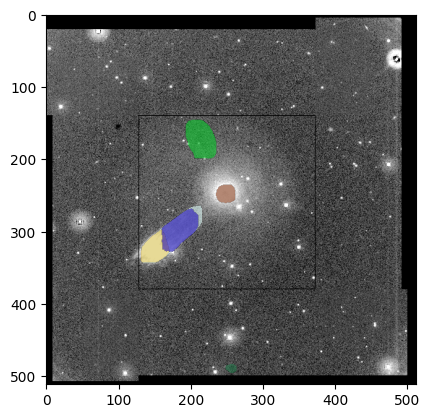

Image ../XMM_OM_dataset/zscaled_512_stretched/S0822150301_U.png


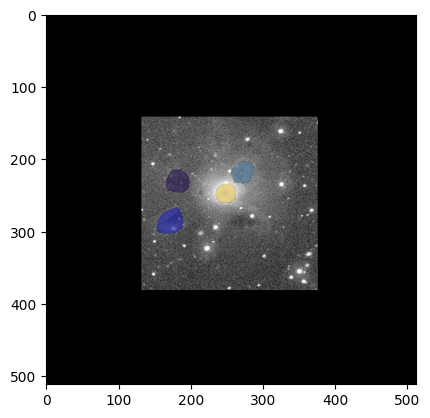

Image ../XMM_OM_dataset/zscaled_512_stretched/S0853190101_S.png


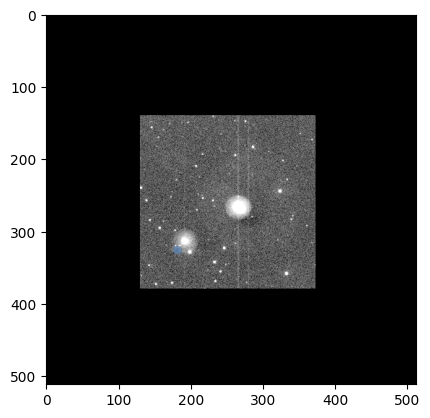

Image ../XMM_OM_dataset/zscaled_512_stretched/S0413580101_U.png


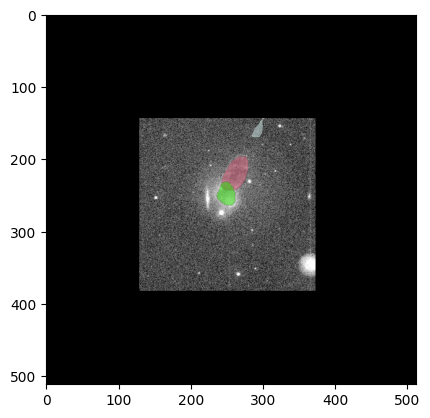

Image ../XMM_OM_dataset/zscaled_512_stretched/S0800840201_L.png


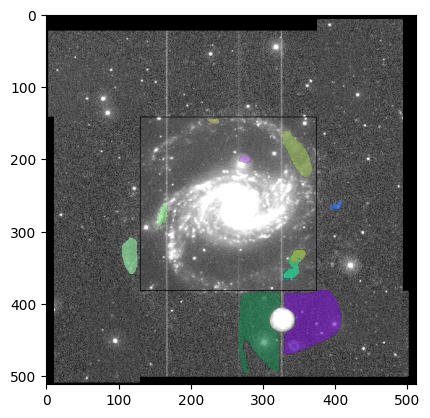

Image ../XMM_OM_dataset/zscaled_512_stretched/S0893400301_S.png


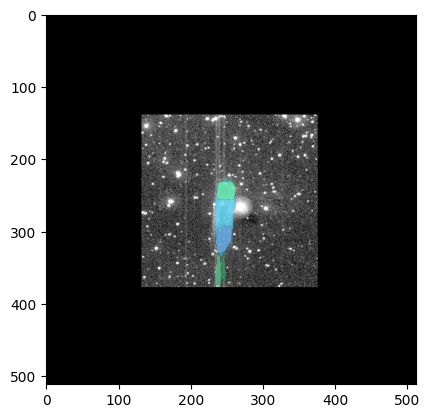

Image ../XMM_OM_dataset/zscaled_512_stretched/S0140160101_M.png


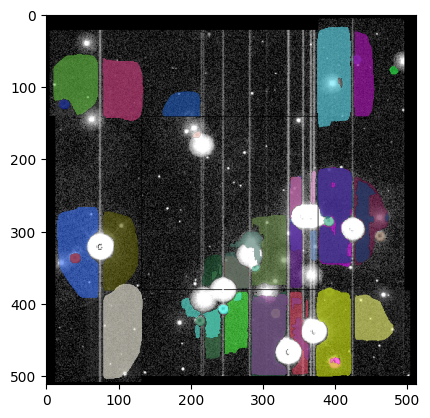

In [45]:
import time
import cv2

new_images_dir = '../XMM_OM_dataset/zscaled_512_stretched/'
new_image_files =  os.listdir(new_images_dir)

for image_name in new_image_files[2010:2030]:
    img = mmcv.imread(new_images_dir+image_name,channel_order='rgb')
    new_result = inference_detector(model, img)
    print('Image', new_images_dir+image_name)
    image = cv2.imread(new_images_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = new_result.pred_instances
    plt.imshow(img)
    show_masks(new_result.pred_instances.masks.cpu().numpy(), plt.gca())
    plt.show()
    plt.close()

    if export_to_Roboflow:
        mmdet_export_image_det_to_Roboflow(new_images_dir, image_name, results)